This notebook combines the modifications to the original libri-light ABX evaluation:  
  
  * Tu Anh Nguyen's phone-specific ABX evaluation, written only for checkpoint-based setup
  * eval_ABX.py original setup, allowing files-from-directory setup
  * ZeroSpeech ABX evaluation, allowing for the aforementioned files to be .txt format too  
      * [here](https://github.com/zerospeech/zerospeech2021/blob/master/zerospeech2021/phonetic.py)

## base setup  
  
lifted from eval_ABX.py

In [1]:
from pathlib import Path
import argparse
import sys
import torch
import json
import numpy as np
import pandas as pd
import yaml
import os
from os.path import join, exists, dirname, splitext, basename, abspath
os.getcwd()


def find_all_files(path_dir, extension):
    out = []
    for root, dirs, filenames in os.walk(path_dir):
        for f in filenames:
            if f.endswith(extension):
                out.append(((str(Path(f).stem)), os.path.join(root, f)))
    return out

# from zerospeech's ABX: all the submission features collections are in .txt format
def load_txt(x):
    data = torch.tensor(np.loadtxt(x))
    assert (len(data.size()) == 2)
    return data


## cpc setup  
  
(not relevant for running this on features from directory, which is format for ZR submissions)

In [ ]:
import sys
sys.path.append("CPC_audio")
from cpc.feature_loader import buildFeature, FeatureModule, loadModel

# cpc.feature_loader has requirements listed in its environment.yml file which nevertheless were
# not installed while setting up the env per cpc's instructions
# in particular: tqdm and soundfile

def loadCPCFeatureMaker(CPC_pathCheckpoint, encoder_layer=False, keepHidden=True, gru_level = -1, cuda=False):
    if gru_level and gru_level > 0:
        updateConfig = argparse.Namespace(nLevelsGRU=gru_level)
    else:
        updateConfig = None
    model, nHiddenGar, nHiddenEncoder = loadModel([CPC_pathCheckpoint], updateConfig=updateConfig)
    if encoder_layer:
        nFeatures = nHiddenEncoder
    else:
        nFeatures = nHiddenGar
    model.gAR.keepHidden = keepHidden
    featureMaker = FeatureModule(model, get_encoded=encoder_layer)
    featureMaker.eval()
    if cuda:
        featureMaker.cuda()
    print("Checkpoint loaded!")
    print("")

    return featureMaker, nFeatures

def get_feature_function_CPC(CPC_pathCheckpoint, 
    encoder_layer=False, keepHidden=True, gru_level=-1, cuda=False):
    ## Load CPC featureMaker
    featureMaker, _ = loadCPCFeatureMaker(CPC_pathCheckpoint, encoder_layer=encoder_layer, keepHidden=keepHidden, gru_level = gru_level, cuda=cuda)
    def feature_function(x): 
        return buildFeature(featureMaker, x,
                                seqNorm=False,
                                strict=True,
                                maxSizeSeq=64000)[0]
    ff_args = {}
    ff_args["name"] = "feature_function_CPC"
    ff_args["CPC_pathCheckpoint"] = abspath(CPC_pathCheckpoint)
    ff_args["encoder_layer"] = encoder_layer
    ff_args["keepHidden"] = keepHidden
    ff_args["gru_level"] = gru_level
    ff_args["step_feature_multiplication"] = 1
    ff_args["cuda_feature"] = cuda

    return feature_function, ff_args

#CPC_checkpoint = "/scratch2/tnguyen/Projects/domain-adaptation/runs/runs-JeanZay/cpc/1_cpc-ls100/checkpoint_49.pt"
#CPC_checkpoint = "/scratch2/alyashenko/ABX_tests/CPC-big-kmeans50/cpc_ll6k/checkpoint_32.pt"
CPC_checkpoint = "/scratch2/alyashenko/ABX_tests/CPC-small-kmeans50/cpc_ls100/checkpoint_170.pt"
feature_function, ff_args = get_feature_function_CPC(
                                                        CPC_checkpoint, 
                                                        encoder_layer=False, keepHidden=True,
                                                        gru_level=-1, cuda=False)

# add new feature_function (load_txt) and new ff_args appropriate for read-from-folder ABX

## ABX setup

In [2]:
import ABX_src.abx_group_computation as abx_g
import ABX_src.abx_iterators as abx_it #regular iterators = out-the-box ABX
import ABX_src.phone_abx_iterators as phone_abx_it #phone_abx_iterators = Tu Anh's bespoke mod

In [3]:
def reduce_sparse_data(quotient, divisor):
    return quotient / (1e-08 * (divisor == 0) + divisor)

# Distance function
distance_function = abx_g.get_distance_function_from_name('cosine')

max_size_group = 10
max_x_across = 5

In [4]:
# Set up for unsupervised ABX eval loop:

subm_path = "/scratch1/projects/zerospeech/2021/submissions/"

# "submissions": a list of dictionaries containing one entry per ZS2021 submission (considered here)
# each dictionary has
# "path_dir": path to "phonetic" directory of submission
#      /scratch1/projects/zerospeech/2021/submissions/[name]/(submission/)phonetic/
#      some directories have a "submission" layer, some don't; needs checked every time
# "name": name to use for results, i.e. name of folder under .../2021/submissions/
# "path_scores": path to submission's original scores (now irrelevant/duplicated elsewhere)

# if the item is single-commented (#), it's been calculated for within speaker (both contexts) and across speaker (within context)
# if the item is double-commented (##), (null)
# if the item is triple-commented (###), there was a problem of some sort (usually, it hasn't been run)

submissions = [
    ### ! vg-low baseline: permission error trying to access scores file ? ? ? 
    ###{"path_dir":subm_path+"zr2021-baseline-vg-low/submission/phonetic/",
    ###    "name":"zr2021-baseline-vg-low",
    ###    "path_scores":subm_path+"zr2021-baseline-vg-low/scores/"},
    ### ! vg-high baseline doesn't have a scores folder:
    ###{"path_dir":subm_path+"zr2021-baseline-vg-high/submission/phonetic/",
    ###    "name":"zr2021-baseline-vg-high",
    ###    "path_scores":subm_path+"zr2021-baseline-vg-high/scores/"}
    {"path_dir":subm_path+"zr2021-baseline-random/submission/phonetic/",
      "name":"zr2021-baseline-random",
      "path_scores":subm_path+"zr2021-baseline-random/scores/"},
    {"path_dir":subm_path+"zr2021-baseline-lstm/submission/phonetic/",
        "name":"zr2021-baseline-lstm",
       "path_scores":subm_path+"zr2021-baseline-lstm/scores/"},
    {"path_dir":subm_path+"zr2021-baseline-bert/submission/phonetic/",
        "name":"zr2021-baseline-bert",
        "path_scores":subm_path+"zr2021-baseline-bert/scores/"},
    {"path_dir":subm_path+"20211104100942_harwath/submission/phonetic/",
        "name":"20211104100942_harwath",
        "path_scores":subm_path+"20211104100942_harwath/scores/"},
    {"path_dir":subm_path+"20210323162500_fyuya/submission/phonetic/",
        "name":"20210323162500_fyuya",
        "path_scores":subm_path+"20210323162500_fyuya/scores/"},
    {"path_dir":subm_path+"20210323162430_fyuya/submission/phonetic/",
         "name":"20210323162430_fyuya",
         "path_scores":subm_path+"20210323162430_fyuya/scores/"},
    {"path_dir":subm_path+"20210323162400_fyuya/submission/phonetic/",
        "name":"20210323162400_fyuya",
         "path_scores":subm_path+"20210323162400_fyuya/scores/"},
    {"path_dir":subm_path+"20210323162300_fyuya/submission/phonetic/",
         "name":"20210323162300_fyuya",
         "path_scores":subm_path+"20210323162300_fyuya/scores/"},
    {"path_dir":subm_path+"tuanh_zs2021_baseline_reimpl/phonetic/",
         "name":"tuanh_zs2021_baseline_reimpl",
         "path_scores":subm_path+"tuanh_zs2021_baseline_reimpl/scores/"},
    {"path_dir":subm_path+"tuanh_hubert_ls960_iter3/phonetic/",
         "name":"tuanh_hubert_ls960_iter3",
         "path_scores":subm_path+"tuanh_hubert_ls960_iter3/scores/"},
    {"path_dir":subm_path+"tuanh_hubert_ls960_iter2/phonetic/",
         "name":"tuanh_hubert_ls960_iter2",
         "path_scores":subm_path+"tuanh_hubert_ls960_iter2/scores/"},
    {"path_dir":subm_path+"saurabh_bhati3/phonetic/",
        "name":"saurabh_bhati3",
        "path_scores":subm_path+"saurabh_bhati3/scores/"},
    {"path_dir":subm_path+"saurabh_bhati2/phonetic/",
        "name":"saurabh_bhati2",
        "path_scores":subm_path+"saurabh_bhati2/scores/"},
    {"path_dir":subm_path+"tuanh_cpc_cont_bert/phonetic/",
         "name":"tuanh_cpc_cont_bert",
         "path_scores":subm_path+"tuanh_cpc_cont_bert/scores/"},
    ### ! lingyun_gao should have 3 submissions per ZR2021 results but only has 1 folder in submissions
    {"path_dir":subm_path+"lingyun_gao/phonetic/",
         "name":"lingyun_gao",
         "path_scores":subm_path+"lingyun_gao/scores/"},
    {"path_dir":subm_path+"adrian_lancucki/submission/phonetic/",
         "name":"adrian_lancucki",
         "path_scores":subm_path+"adrian_lancucki/submission/scores/"},
    ### ! jaeyeonkim99 should have 2 submissions but only 1/2 folders has a "scores" subfolder
    {"path_dir":subm_path+"20211104104359_jaeyeonkim99/submission/phonetic/",
         "name":"20211104104359_jaeyeonkim99",
        "path_scores":subm_path+"20211104104359_jaeyeonkim99/scores/"},
    ###{"path_dir":subm_path+"20211119235733_jaeyeonkim99/submission/phonetic/",
    ###     "name":"20211119235733_jaeyeonkim99",
    ###     "path_scores":subm_path+"20211119235733_jaeyeonkim99/scores/"} <- DNE!!!
    {"path_dir":subm_path+"20210323090151_liucodalab/submission/phonetic/",
        "name":"20210323090151_liucodalab",
        "path_scores":subm_path+"20210323090151_liucodalab/scores/"},
    {"path_dir":subm_path+"20210323044200_chorowski/submission/phonetic/",
         "name":"20210323044200_chorowski",
         "path_scores":subm_path+"20210323044200_chorowski/scores/"},
    {"path_dir":subm_path+"20210323021100_chorowski/submission/phonetic/",
         "name":"20210323021100_chorowski",
         "path_scores":subm_path+"20210323021100_chorowski/scores/"},
    {"path_dir":subm_path+"20210322230044_benjaminvan/submission/phonetic/",
         "name":"20210322230044_benjaminvan",
         "path_scores":subm_path+"20210322230044_benjaminvan/scores/"},
    ]


In [41]:
# function for ABX for specific ZR2021 submission

def ABX_speaker_context(path_dir, name, subkind, speaker, context):
    """
    path_dir: str
    name: str
    subkind: str ("dev-clean"/"dev-other"/"test-clean"/"test-other")
    speaker: "within" or "across" str (this choice of variable name is a bit confusing, my bad)
    context: "within" or "without" str
    """
    # score storage 
    ## 04/2022: changed to num value instead of dictionary
    ## because each run of this ABX function only returns 1 score value anyway
    score = 0
   
    # data path: each submission's own path
    path_data = path_dir+subkind+"/"
    
    # (p)item path: 
    ## Tu Anh's pitems have 5 elements per line: file, start, end, phone, speaker
    # path_item_file = "/scratch2/tnguyen/datasets/pABX/librispeech/{}.pitem".format(subkind)
    ## Lyashenko's pitems have 7 elements per line: file, start, end, phone, prevphone, nextphone, speaker
    path_item_file = "/scratch2/alyashenko/item_from_alignment/{}.pitem".format(subkind)
    
    # reading frame step from submission meta file:
    # (this file is always located as sister to the "phonetic" folder, wherever that may be)
    # ((if we're lucky))
    path_meta_file = (path_dir[:-1].rpartition("/")[0])+"/meta.yaml"
    with open(path_meta_file, 'r') as stream:
        meta_data = yaml.safe_load(stream)
    frame_step = 1/(meta_data["parameters"]["phonetic"]["frame_shift"])
    
    # make sequence list
    seq_list = find_all_files(path_dir=path_data, 
                          extension=".txt")
    with open(path_item_file) as f:
        lines = f.read().strip().split("\n")
    files_set = set([item.split()[0] for item in lines[1:]])
    seq_list = [item for item in seq_list if item[0] in files_set]
    print(len(seq_list), "sequences found!")

    # feature_function from ZS2021 phonetic.py
    feature_function = load_txt

    # make ABX dataset (FeatureLoader object depends on context type)
    if context=="within":
        # requires path_item_file to have 7 columns: file, start, end, phone, prevphone, nextphone, speaker
        ABXDataset = abx_it.ABXFeatureLoader(path_item_file, seq_list,
                                    feature_function, frame_step, True)
    else:
        # requires path_item_file to have 5 columns: file, start, end, phone, speaker
        ABXDataset = phone_abx_it.phoneABXFeatureLoader(
                                    path_item_file, seq_list,
                                    feature_function, frame_step, True) #num value = frame step in ms
    # (outputs progress + "done") when done
    
    # proceed with ABX (dependent on speaker type)
    print("Computing ABX within speakers...")
    ABXIterator = ABXDataset.get_iterator(speaker, max_size_group)
    if speaker=="across":
        ABXIterator.max_x = max_x_across
    
    # group confusion score: 
    group_confusion = abx_g.get_abx_scores_dtw_on_group(ABXIterator,
                                                    distance_function,
                                                    ABXIterator.symmetric)
    
    # doing the math
    n_data = group_confusion._values().size(0)
    index_ = torch.sparse.LongTensor(group_confusion._indices(),
                                 torch.ones((n_data), dtype=torch.float),
                                 group_confusion.size())
    
    # some of the math depends on context/speaker types
    
    if context=="without" and speaker=="within":
        # Tu Anh's treatment of group_confusion & divisor_context:
        # (peculiar for 
        divisor_context = index_.to_dense()
        group_confusion = group_confusion.to_dense()
    else:
        if context=="without":  # i.e. across-speaker, without-context
            dimn = [3] 
        elif speaker=="across": # i.e. across-speaker, within-context
            dimn = [3,4]
        else:                   # i.e. within-speaker, within-context
            dimn = 3
        # lines lifted from eval_ABX.py 
        divisor_context = torch.sparse.sum(index_, dim=dimn).to_dense()
        group_confusion = torch.sparse.sum(group_confusion, dim=dimn).to_dense()
        
        # why doesn't this last line get run for within-speaker without-context???
        # I can't see a reason, might ask Tu Anh ? 
        group_confusion = reduce_sparse_data(group_confusion, divisor_context)

    S, p1, p2 = group_confusion.size()

    index_speaker = divisor_context > 0
    divisor_speaker = index_speaker.sum(dim=0)
    phone_confusion = reduce_sparse_data(group_confusion.sum(dim=0),
                                     divisor_speaker)

    
    score = (phone_confusion.sum() / (divisor_speaker > 0).sum()).item()
    
    print("...done. {} ABX {}-speaker {}-context {} : {}".format(
        name, speaker, context, subkind, score))
    
    # extra step: saving confusion matrix data
    cfs = phone_confusion.numpy()
    pd.DataFrame(cfs).to_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/confusion_matrices/{}_{}_{}_{}.csv".format(
            name,speaker,context,subkind))
    
    return score

def save_scores(submission, newabx):
    """
    reads in pre-existing ABX scores for given submission, adds phone-based ABX scores (newabx), saves to csv
    submission: dictionary with "path_dir" (features directory), "name", and "path_scores" (scores directory) values
    newabx: pandas DataFrame with "dataset", "sub-dataset", "speaker-type", "context-type", "score" columns
    """
    try:
        # oldabx = pd.read_csv(submission["path_scores"]+"score_phonetic.csv")
        oldabx = pd.read_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/oldscores/{}.csv".format(submission["name"]))
        allabx = pd.concat([oldabx,newabx],ignore_index=True)
    except:
        print("error retrieving previous ABX results for {}. saving new ABX results only.".format(submission["name"]))
        allabx = newabx
    
    # save location can be altered:
    allabx.to_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/{}.csv".format(submission["name"]), index=False)
    print("{} results saved".format(submission["name"]))
    

**The cell above** is the function that the cell below calls at every loop. It takes a "subkind", a "speaker(-type)", and a "context(-type)" as parameters every time.    
  
**The cell below** is a loop calling the above function. It comes with modifiable lists of parameters to be looped over.  
The parameters are the aforementioned *subkinds* (sub-datasets), *speaker-types*, and *context-types*. The maximal set-up would be:  
  
    subkinds = ["dev-clean","dev-other","test-clean","test-other"]  
    speakertypes = ["within", "across"]  
    contexttypes = ["within", "without"]  
  
A third context-type could be implemented - `"triphone"` - if the `ABX_speaker_context` function were modified to work with legacy ".item" files rather than just ".pitem" files. At present, this context-type is only used in old results.  
                

In [ ]:
# list of subkinds: these are also subdirectories in each submission's "/phonetic/" folder
subkinds = ["dev-clean","dev-other","test-clean","test-other"]
##subkinds = ["test-toy"]
speakertypes = ["across"]
contexttypes = ["within"]

# scores storage:
ABX_scores = {}
# each entry is of the format {"name": score}, where score is a pandas DataFrame
# (to comply with ZS2021 scores outputs)
# DataFrame score has columns ["dataset", "sub-dataset", "speaker-type", "context-type", "score"]
# dataset: dev / test
# sub-dataset: clean / other
# speaker-type: within / across
# context-type: within / without / triphone(legacy scores only)
# score: ABX score

# running the loop function over the "submissions" list and the "subkinds" list
for submission in submissions:
    results = {}
    for subkind in subkinds:
        for spkr in speakertypes:
            for ctxt in contexttypes:
                results["{}-{}-{}".format(subkind,spkr,ctxt)] = ABX_speaker_context(submission["path_dir"], submission["name"], subkind, spkr, ctxt)
    results2 =  [(dset.split('-')[0], dset.split('-')[1], dset.split('-')[2]+"_s", dset.split('-')[3]"_c", score)  
            for dset, score in results.items()]
    ABX_scores[submission["name"]] = pd.DataFrame(results2, columns=['dataset', 'sub-dataset', 'speaker-type', 'context-type', 'score'])
    # saving results:  
    save_scores(submission,ABX_scores[submission["name"]])


There is a **notable inefficiency** in this loop + function combination:  
  
Building the ABXDataset object requires only knowing the subkind + context-type. Within a given subkind (sub-dataset) + context-type combination, the same ABXDataset object could be reused for both speaker-types.  
  
At present, the ABXDataset object is rebuilt at every run of the loop, and it takes a decently long time. 4 subkinds x 2 speaker-types x 2 context-types = it is built 16 times total. This number could be cut in two (8 times total) if this step - building ABXDataset - were somehow extracted to just outside the "`for spkr in speakertypes:`" step of the loop.  
  
This should be considered for the future, although it would require streamlining the evaluation overall.  
ABXDataset building requires other elements that are invoked within the `ABX_speaker_context` function: `path_item_file` is accessible directly, `feature_function` can be a global variable, but `frame_step` and `seq_list` need more complex manipulations before they are available for the building step. These manipulations would also have to be pulled out of the function into the surrounding loop. (`seq_list` could even be pulled out to the subkind step of the loop - it stays the same for all speaker-types and context-types.)  
These pre-loaded variables would then have to be passed as parameters to `ABX_speaker_context` to be used within its internal operations. (On second thought, it would only need to pass ABXDataset - the rest are not referenced once ABXDataset is created)  
  
But it's possible!  
   
It would be something like this (calling `ABX_speaker_context_new` to keep the two distinct): 

In [ ]:
subkinds = ["dev-clean","dev-other","test-clean","test-other"]
speakertypes = ["across", "within"] # it only makes a difference when there's both speakertypes...
contexttypes = ["without", "within"]

feature_function = load_txt # defined earlier in notebook

ABX_scores = {}

for submission in submissions:
    # submission's directory
    path_dir = submission["path_dir"]
    
    # getting frame_step (stays static throughout submission)
    path_meta_file = (path_dir[:-1].rpartition("/")[0])+"/meta.yaml"
    with open(path_meta_file, 'r') as stream:
        meta_data = yaml.safe_load(stream)
    frame_step = 1/(meta_data["parameters"]["phonetic"]["frame_shift"])
    
    results = {}
    
    for subkind in subkinds:  
        # loading submission's own features x subkind's .pitem file
        path_data = path_dir+subkind+"/"  
        path_item_file = "/scratch2/alyashenko/item_from_alignment/{}.pitem".format(subkind)
        
        # making sequence list
        seq_list = find_all_files(path_dir=path_data, extension=".txt")
        with open(path_item_file) as f:
            lines = f.read().strip().split("\n")
        files_set = set([item.split()[0] for item in lines[1:]])
        seq_list = [item for item in seq_list if item[0] in files_set]
        print(len(seq_list), "sequences found!")
        
        for ctxt in contexttypes:
            # making ABXDataset, depending on context-type
            if ctxt=="within":
                ABXDataset = abx_it.ABXFeatureLoader(path_item_file, seq_list,
                                    feature_function, frame_step, True)
            else:
                ABXDataset = phone_abx_it.phoneABXFeatureLoader(
                                    path_item_file, seq_list,
                                    feature_function, frame_step, True)
            for spkr in speakertypes:
                results["{}-{}-{}".format(subkind,spkr,ctxt)] = ABX_speaker_context_new(
                    submission["path_dir"], submission["name"], subkind, spkr, ctxt, ABXDataset)
                
    results2 =  [(dset.split('-')[0], dset.split('-')[1], dset.split('-')[2]+"_s", dset.split('-')[3]+"_c", score)  
            for dset, score in results.items()]
    ABX_scores[submission["name"]] = pd.DataFrame(results2, columns=['dataset', 'sub-dataset', 'speaker-type', 'context-type', 'score'])
    # saving results:  
    save_scores(submission,ABX_scores[submission["name"]])

In [5]:
# function for ABX for specific ZR2021 submission
# which assumes that the ABXDataset was created in the loop in the above cell ! ! !

def ABX_speaker_context_new(path_dir, name, subkind, speaker, context, abxdataset):
    """
    path_dir: str
    name: str
    subkind: str ("dev-clean"/"dev-other"/"test-clean"/"test-other")
    speaker: "within" or "across" str (this choice of variable name is a bit confusing, my bad)
    context: "within" or "without" str
    abxdataset: ABXDataset object built specific to subkind + context
    """
    # score storage 
    ## 04/2022: changed to num value instead of dictionary
    ## because each run of this ABX function only returns 1 score value anyway
    score = 0
    
    ABXDataset = abxdataset
    
    # proceed with ABX (dependent on speaker type)
    print("Computing ABX {} speaker {} context...".format(speaker,context))
    ABXIterator = ABXDataset.get_iterator(speaker, max_size_group)
    if speaker=="across":
        ABXIterator.max_x = max_x_across
    
    # group confusion score: 
    group_confusion = abx_g.get_abx_scores_dtw_on_group(ABXIterator,
                                                    distance_function,
                                                    ABXIterator.symmetric)
    
    # doing the math
    n_data = group_confusion._values().size(0)
    index_ = torch.sparse.LongTensor(group_confusion._indices(),
                                 torch.ones((n_data), dtype=torch.float),
                                 group_confusion.size())
    
    # some of the math depends on context/speaker types
    
    if context=="without" and speaker=="within":
        # Tu Anh's treatment of group_confusion & divisor_context:
        # (peculiar for 
        divisor_context = index_.to_dense()
        group_confusion = group_confusion.to_dense()
    else:
        if context=="without":  # i.e. across-speaker, without-context
            dimn = [3] 
        elif speaker=="across": # i.e. across-speaker, within-context
            dimn = [3,4]
        else:                   # i.e. within-speaker, within-context
            dimn = 3
        # lines lifted from eval_ABX.py 
        divisor_context = torch.sparse.sum(index_, dim=dimn).to_dense()
        group_confusion = torch.sparse.sum(group_confusion, dim=dimn).to_dense()
        
        # why doesn't this last line get run for within-speaker without-context???
        # I can't see a reason, might ask Tu Anh ? 
        group_confusion = reduce_sparse_data(group_confusion, divisor_context)

    S, p1, p2 = group_confusion.size()

    index_speaker = divisor_context > 0
    divisor_speaker = index_speaker.sum(dim=0)
    phone_confusion = reduce_sparse_data(group_confusion.sum(dim=0),
                                     divisor_speaker)

    
    score = (phone_confusion.sum() / (divisor_speaker > 0).sum()).item()
    
    print("...done. {} ABX {}-speaker {}-context {} : {}".format(
        name, speaker, context, subkind, score))
    
    # extra step: saving confusion matrix data
    cfs = phone_confusion.numpy()
    pd.DataFrame(cfs).to_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/confusion_matrices/{}_{}_{}_{}.csv".format(
            name,speaker,context,subkind))
    
    return score

def save_scores(submission, newabx):
    """
    reads in pre-existing ABX scores for given submission, adds phone-based ABX scores (newabx), saves to csv
    submission: dictionary with "path_dir" (features directory), "name", and "path_scores" (scores directory) values
    newabx: pandas DataFrame with "dataset", "sub-dataset", "speaker-type", "context-type", "score" columns
    """
    try:
        # oldabx = pd.read_csv(submission["path_scores"]+"score_phonetic.csv")
        oldabx = pd.read_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/oldscores/{}.csv".format(submission["name"]))
        allabx = pd.concat([oldabx,newabx],ignore_index=True)
    except:
        print("error retrieving previous ABX results for {}. saving new ABX results only.".format(submission["name"]))
        allabx = newabx
    
    # save location can be altered:
    allabx.to_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/{}.csv".format(submission["name"]), index=False)
    print("{} results saved".format(submission["name"]))
    

### temporary measures integrated into above loop, or one-off fixes that need not be in the loop

In [13]:
path_dir_test = subm_path+"tuanh_hubert_ls960_iter2/phonetic/"
name_test = "tuanh_hubert_ls960_iter2"

path_meta_file = (path_dir_test[:-1].rpartition("/")[0])+"/meta.yaml"
with open(path_meta_file, 'r') as stream:
    meta_data = yaml.safe_load(stream)

print(meta_data)

{'author': 'Tu Anh et al.', 'affiliation': 'Inria & EHESS, ENS, PSL Research Univerity, CNRS', 'description': 'HuBERT model (https://arxiv.org/abs/2106.07447) trained on librispeech 960,  2nd iteration. 1st iteration: discrete targets obtained by clustering MFCC  features with k-means (k=100). 2nd iteration: discrete targets obtained  by clustering 6th-layer features of 1st iteration with k-means (k=500). ABX is reported on the targets features used to train the 2nd iteration.\n', 'open_source': False, 'train_set': 'librispeech 960', 'visually_grounded': False, 'gpu_budget': 2112, 'parameters': {'phonetic': {'metric': 'cosine', 'frame_shift': 0.02}, 'semantic': {'metric': 'cosine', 'pooling': 'max'}}}


In [13]:
# a score reformatting functions dump

def fix_scores_1(submission):
    # including old scores just in case, calling them "triphone context":
    old = (pd.read_csv("/scratch2/alyashenko/ABX_tests/new_items/scores_{}.csv".format(submission["name"])))[0:8]
    new = pd.DataFrame({"dataset": old["dataset"], "sub-dataset": old["sub-dataset"],
                       "speaker-type": old["type"], "context-type": "triphone", "score": old["score"]})
    # adding within-speaker without-context:
    old1 = (pd.read_csv("/scratch2/alyashenko/ABX_tests/phonetic_phoneABX_{}.csv".format(submission["name"])))[8:12]
    new1 = pd.DataFrame({"dataset": old1["dataset"], "sub-dataset": old1["sub-dataset"],
                       "speaker-type": "within", "context-type": "without", "score": old1["score"]})
    # adding within-speaker within-context:
    old2 = (pd.read_csv("/scratch2/alyashenko/ABX_tests/new_items/scores_{}.csv".format(submission["name"])))[8:12]
    new2 = pd.DataFrame({"dataset": old2["dataset"], "sub-dataset": old2["sub-dataset"],
                       "speaker-type": "within", "context-type": "within", "score": old2["score"]})
    # add it all together and save
    final = pd.concat([new, new1, new2],ignore_index=True)
    final.to_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/oldscores/{}.csv".format(submission["name"]), index=False)
    print("{} scores reformatted and saved".format(submission["name"]))
    
def fix_scores(submission):
    old = (pd.read_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/{}.csv".format(submission["name"])))
    old["speaker-type"] = old["speaker-type"].replace(["within","across"],["within_s","across_s"])
    old["context-type"] = old["context-type"].replace(["within","without","triphone"],["within_c","without_c","on_triphone"])
    old.to_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/{}.csv".format(submission["name"], index=False))
    print("{} score labels fixed".format(submission["name"]))

In [14]:
for submission in submissions: # run on ALL submissions once theyve been made into results after across-s-within-c abx
    fix_scores(submission)

zr2021-baseline-random score labels fixed
zr2021-baseline-lstm score labels fixed
zr2021-baseline-bert score labels fixed
20211104100942_harwath score labels fixed
20210323162500_fyuya score labels fixed
20210323162430_fyuya score labels fixed
20210323162400_fyuya score labels fixed
20210323162300_fyuya score labels fixed
tuanh_zs2021_baseline_reimpl score labels fixed
tuanh_hubert_ls960_iter3 score labels fixed
tuanh_hubert_ls960_iter2 score labels fixed
saurabh_bhati3 score labels fixed
saurabh_bhati2 score labels fixed
tuanh_cpc_cont_bert score labels fixed
lingyun_gao score labels fixed
adrian_lancucki score labels fixed
20211104104359_jaeyeonkim99 score labels fixed
20210323090151_liucodalab score labels fixed
20210323044200_chorowski score labels fixed
20210323021100_chorowski score labels fixed
20210322230044_benjaminvan score labels fixed


In [ ]:
# changing this one submission which had pulled the wrong scores already
old = (pd.read_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/20211104100942_harwath.csv"))
oldstart = old[0:8]
oldend = old[12:20]

corr = (pd.read_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/oldscores/20211104100942_harwath.csv"))[8:12]

final = pd.concat([oldstart, corr, oldend],ignore_index=True)
final.to_csv("/scratch2/alyashenko/ABX_tests/ABX_speaker_context/20211104100942_harwath.csv", index=False)
print("scores reformatted and saved")

In [37]:
names = phoneABX_scores.keys()
for name in names:
    phoneABX_scores[name].to_csv("/scratch2/alyashenko/ABX_tests/{}_phoneABX.csv".format(name))
    print("{} results saved".format(name))

zr2021-baseline-vg-low results saved


In [28]:
for submission in submissions:
    oldabx = pd.read_csv(submission["path_scores"]+"score_phonetic.csv")
    newabx = phoneABX_scores[submission["name"]].replace("within","within-phone")
    allabx = pd.concat([oldabx,newabx],ignore_index=True)
    print(allabx)
    allabx.to_csv("/scratch2/alyashenko/ABX_tests/phonetic_phoneABX_{}.csv".format(submission["name"]))

   dataset sub-dataset          type     score
0      dev       clean        within  0.034300
1      dev       clean        across  0.041700
2      dev       other        within  0.048400
3      dev       other        across  0.075900
4     test       clean        within  0.032800
5     test       clean        across  0.043100
6     test       other        within  0.048100
7     test       other        across  0.079200
8      dev       clean  within-phone  0.068157
9      dev       other  within-phone  0.094322
10    test       clean  within-phone  0.068374
11    test       other  within-phone  0.096068
   dataset sub-dataset          type     score
0      dev       clean        within  0.169600
1      dev       clean        across  0.245200
2      dev       other        within  0.196500
3      dev       other        across  0.298900
4     test       clean        within  0.171400
5     test       clean        across  0.238700
6     test       other        within  0.204000
7     test   

# steps for manual within phone ABX  
  
these were essentially rolled into the `within_phone_ABX` (edit: now `ABX_speaker_context`) function above

In [ ]:
# Get the list of sequences (lifted from tnguyen/eval_ABX original)
# > sub dev/test and clean/other in all 4 combinations (dev-clean, dev-other, test-clean, test-other)
# > make sure to change this in both paths so they match

    ## toy files:
    #path_data = "/scratch2/tnguyen/notebooks/ZR2021/evaluations/evaluations_ABX/develop/test-toy/audio"
    #path_item_file = "/scratch2/tnguyen/notebooks/ZR2021/evaluations/evaluations_ABX/develop/test-toy/test-toy.pitem"

# feature files to be fed in (change directory+subdirectory with each model)
# /scratch1/projects/zerospeech/2021/submissions/.../(submission/)phonetic/[dev|test]-[clean|other]/
# (some non-baseline directories have a "submission" layer, some don't; needs checked every time)
path_data = "/scratch1/projects/zerospeech/2021/submissions/zr2021-baseline-lstm/submission/phonetic/dev-clean/"
# pitem file to be fed in (change only last element to match subdirectory of submitted model)
path_item_file = "/scratch2/tnguyen/datasets/pABX/librispeech/dev-clean.pitem"


seq_list = find_all_files(path_dir=path_data, 
                          extension=".txt") # <- changed from .flac for cpc checkpoint

with open(path_item_file) as f:
    lines = f.read().strip().split("\n")
files_set = set([item.split()[0] for item in lines[1:]])

seq_list = [item for item in seq_list if item[0] in files_set]
print(len(seq_list), "sequences found!")

# ABX dataset

# for feature-files-from-dir approach; comment out if using CPC checkpoint method:
feature_function = load_txt

phoneABXDataset = phone_abx_it.phoneABXFeatureLoader(
                                    path_item_file, seq_list,
                                    feature_function, 100, True)



In [51]:
print(phoneABXDataset.get_n_speakers(), "speakers")
print(phoneABXDataset.get_n_phone(), "phones")

40 speakers
39 phones


In [52]:
scores = {}
max_size_group = 10

## within

In [53]:
print("Computing ABX within speakers...")
ABXIterator = phoneABXDataset.get_iterator('within', max_size_group)

Computing ABX within speakers...


In [54]:
group_confusion = abx_g.get_abx_scores_dtw_on_group(ABXIterator,
                                                    distance_function,
                                                    ABXIterator.symmetric)

100% |########################################################################|


In [56]:
n_data = group_confusion._values().size(0)
index_ = torch.sparse.LongTensor(group_confusion._indices(),
                                 torch.ones((n_data),
                                            dtype=torch.float),
                                 group_confusion.size())
divisor_context = index_.to_dense()
group_confusion = group_confusion.to_dense()
S, p1, p2 = group_confusion.size()

index_speaker = divisor_context > 0
divisor_speaker = index_speaker.sum(dim=0)
phone_confusion = reduce_sparse_data(group_confusion.sum(dim=0),
                                     divisor_speaker)

scores['within'] = (phone_confusion.sum() /
                    (divisor_speaker > 0).sum()).item()
print(f"...done. ABX within : {scores['within']}")

# for lstm baseline dev-clean within: ...done. ABX within : 0.06823188066482544

...done. ABX within : 0.06823188066482544


# postscriptum - results re-processing

In [31]:
withinsp = pd.read_csv("/scratch2/alyashenko/ABX_tests/CPC-small-kmeans50_cpc_ls100_checkpoint_170_withinspeaker.csv",index_col=0).values


In [16]:
import seaborn as sn
import matplotlib.pyplot as plt

def plot_cfs(cfs, indexes, fmt = '.2f'):
    df_cm = pd.DataFrame(cfs[indexes][:,indexes], 
                         index = [phones_list[i] for i in indexes],
                         columns = [phones_list[i] for i in indexes])
    plt.figure(figsize = (20,14))
    sn.heatmap(df_cm, annot=True, fmt = fmt)
    plt.show()

#### backtracking to get the indices for the confusion matrix

In [12]:
def load_phone_item_file(path_item_file): #taken from phone_abx_iterators, modified to only return phone_match
    r""" Load a .pitem file indicating the phoneme alignments. The
    input file must have the following fomat:
    line 0 : whatever (not read)
    line > 0: #file_ID onset offset #phone speaker
    onset : begining of the phoneme (in s)
    offset : end of the phoneme (in s)
    """
    with open(path_item_file, 'r') as file:
        data = file.readlines()[1:]
    data = [x.replace('\n', '') for x in data]

    phone_match = {}
    
    for line in data:
        items = line.split()
        assert(len(items) == 5)
        #fileID = items[0]
        #if fileID not in out:
        #    out[fileID] = []

        onset, offset = float(items[1]), float(items[2])
        phone = items[3]
        speaker = items[4]

        if phone not in phone_match:
            s = len(phone_match)
            phone_match[phone] = s
        phone_id = phone_match[phone]
        
    return phone_match

phone_list = load_phone_item_file(path_item_file)

In [32]:
phones_list = list(phone_list.keys())

vowel_indexes = []
consonant_indexes = []
for i, phone in enumerate(phones_list):
    if phone[0] in ['A','E','O','U','I']:
        vowel_indexes.append(i)
    else:
        consonant_indexes.append(i)

In [33]:
len(phone_list)

39

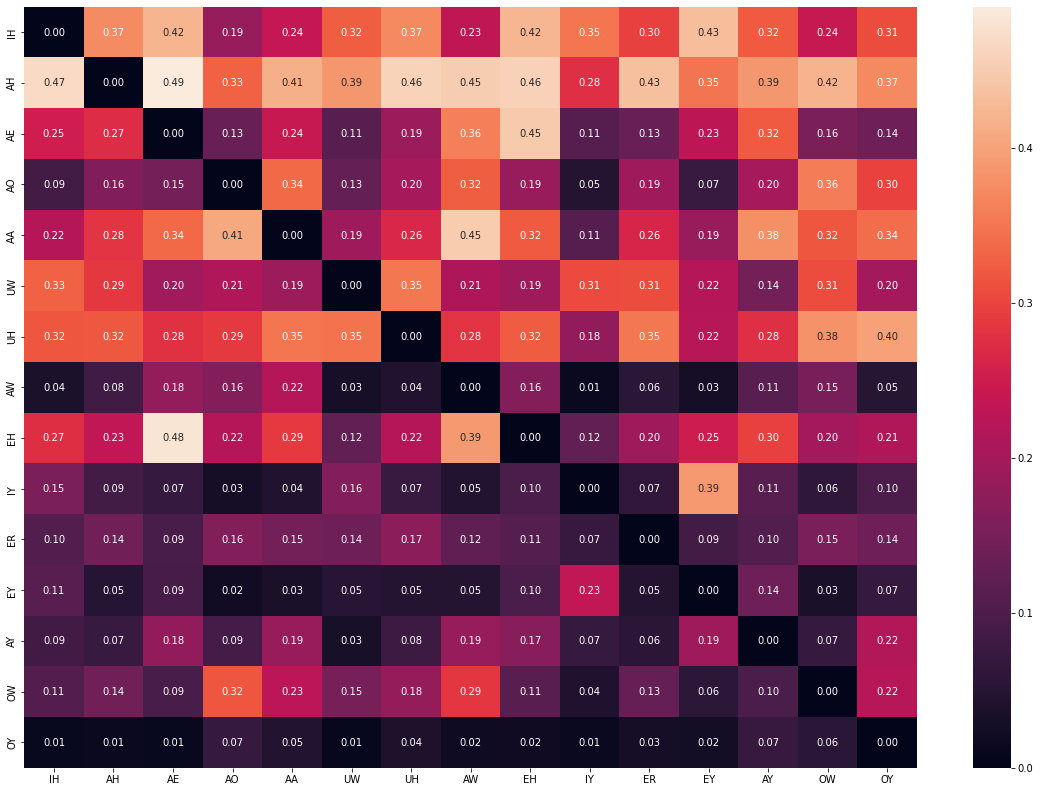

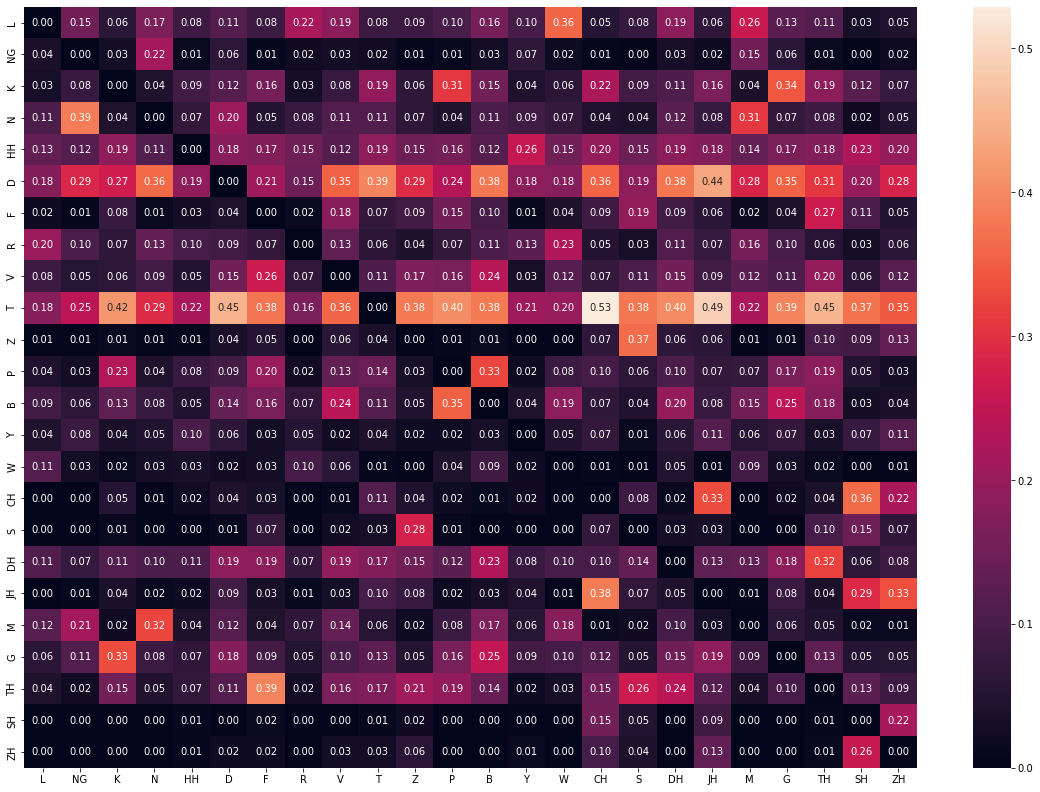

In [34]:
plot_cfs(withinsp, vowel_indexes)
plot_cfs(withinsp, consonant_indexes)

In [35]:
upper = withinsp[np.triu_indices(39, k = 1)]
lower = withinsp[np.tril_indices(39, k = 1)]
nondiag = np.concatenate((upper,lower))

In [28]:
nondiag

array([0.14681499, 0.168195  , 0.08971999, ..., 0.34435984, 0.0041299 ,
       0.        ])

In [29]:
np.average(nondiag) #tu anh (within)

0.11489265966710199

In [36]:
np.average(nondiag) # small-kmeans50 (within)
# result: demonstrably somewhat better as expected! evaluation holds water

0.09693049565572291